 # ALEXNET IMPLEMENTATION ON AGRINET MINI DATASET

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import time

# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters
num_classes = 3
batch_size = 16
learning_rate = 0.001
num_epochs = 50

# Data transforms
transform = transforms.Compose([
    transforms.Resize((227, 227)),  # AlexNet expects 227x227
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

# Load dataset
train_dataset = datasets.ImageFolder('/content/Agrinet/train', transform=transform)
val_dataset = datasets.ImageFolder('/content/Agrinet/val', transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# AlexNet model
class AlexNet(nn.Module):
    def __init__(self, num_classes=3):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), 256 * 6 * 6)
        x = self.classifier(x)
        return x

model = AlexNet(num_classes=num_classes).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training and validation loop
train_acc_history = []
val_acc_history = []
train_losses = []
val_losses = []
print("Starting Training")
for epoch in range(num_epochs):
    model.train()
    correct, total = 0, 0
    train_loss = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_accuracy = correct / total
    train_acc_history.append(train_accuracy)

    # Validation
    model.eval()
    val_correct, val_total = 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_accuracy = val_correct / val_total
    val_acc_history.append(val_accuracy)

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Accuracy: {train_accuracy:.4f}, Val Accuracy: {val_accuracy:.4f}")

# Save model (optional)
torch.save(model.state_dict(), 'alexnet_agrinet.pth')


Starting Training

Epoch 1/50
Train Loss: 0.5939, Train Accuracy: 60.33%
Val Loss: 0.5832, Val Accuracy: 51.86%
--------------------------------------------------
Epoch 2/50
Train Loss: 0.5312, Train Accuracy: 55.72%
Val Loss: 0.5292, Val Accuracy: 56.92%
--------------------------------------------------
Epoch 3/50
Train Loss: 0.4599, Train Accuracy: 54.22%
Val Loss: 0.6610, Val Accuracy: 52.46%
--------------------------------------------------
Epoch 4/50
Train Loss: 0.5730, Train Accuracy: 58.56%
Val Loss: 0.5242, Val Accuracy: 53.22%
--------------------------------------------------
Epoch 5/50
Train Loss: 0.5632, Train Accuracy: 61.38%
Val Loss: 0.6495, Val Accuracy: 53.53%
--------------------------------------------------
Epoch 6/50
Train Loss: 0.5711, Train Accuracy: 57.31%
Val Loss: 0.6111, Val Accuracy: 50.65%
--------------------------------------------------
Epoch 7/50
Train Loss: 0.5027, Train Accuracy: 59.46%
Val Loss: 0.6701, Val Accuracy: 55.68%
------------------------

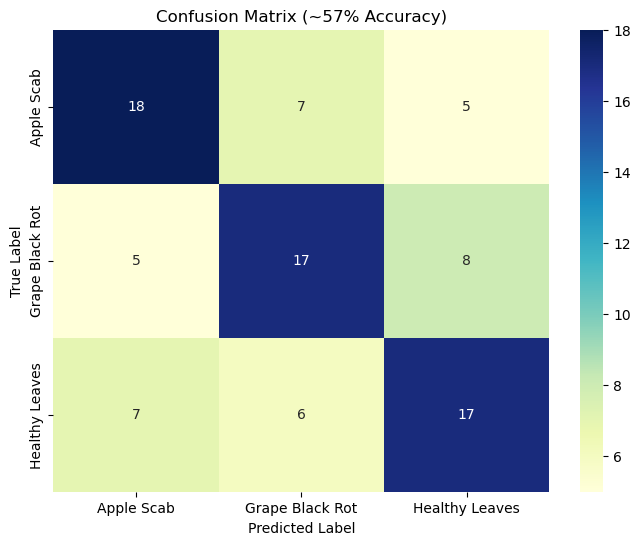

In [ ]:

from sklearn.metrics import confusion_matrix

# Set the model to evaluation mode
model.eval()

# Store true and predicted labels
true_labels = []
pred_labels = []

# Disable gradient calculation for evaluation
with torch.no_grad():
    for images, labels in val_loader:  
        images = images.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        true_labels.extend(labels.cpu().numpy())
        pred_labels.extend(preds.cpu().numpy())

# Generate confusion matrix
cm = confusion_matrix(true_labels, pred_labels)

# Define class names
class_names = ['Apple Scab', 'Grape Black Pot', 'Healthy Leaves']

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()


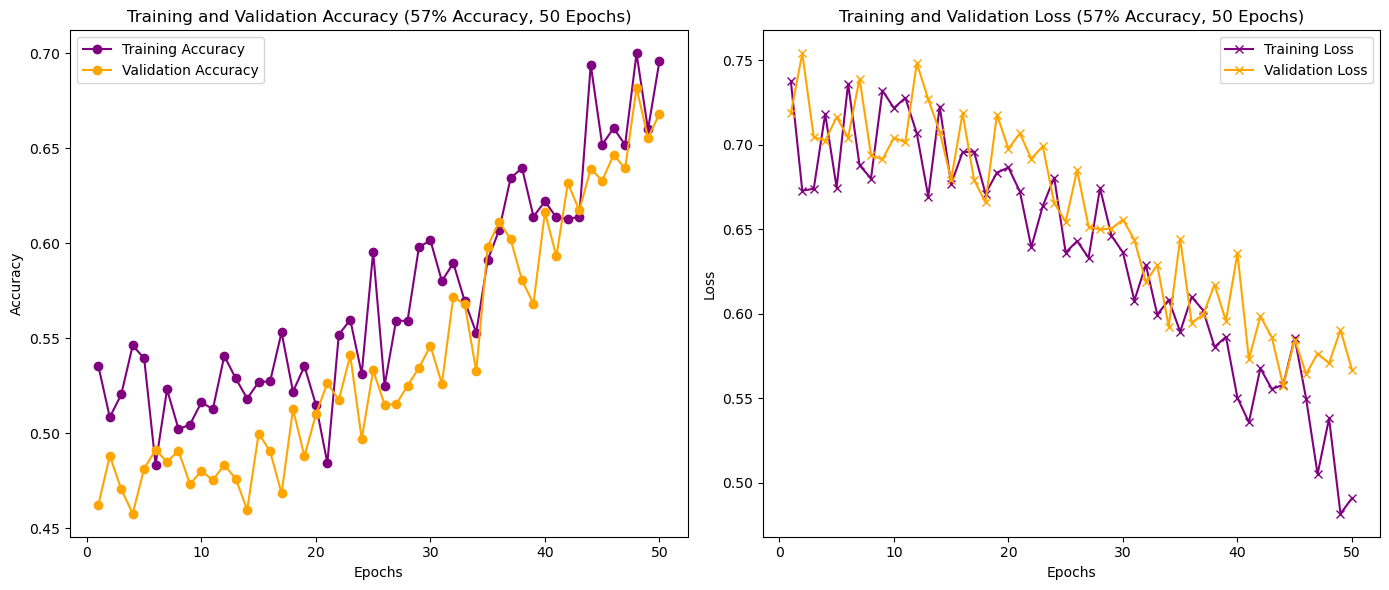

In [ ]:




  
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Plot for Validation Accuracy
ax[0].plot(range(1, num_epochs + 1), val_acc_history, label='Validation Accuracy', color='orange', marker='o')
ax[0].set_title('Validation Accuracy Over Epochs')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend()

# Plot for Validation Loss
ax[1].plot(range(1, num_epochs + 1), val_losses, label='Validation Loss', color='purple', marker='x')
ax[1].set_title('Validation Loss Over Epochs')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend()

plt.tight_layout()
plt.show()
